In [1]:
%pylab inline
from sigvisa import Sigvisa
from sigvisa.source.event import get_event
from sigvisa.infer.coarse_to_fine_init import ModelSpec, EventRunSpec, do_coarse_to_fine, initialize_from, do_inference
from sigvisa.infer.correlations.event_proposal import correlation_location_proposal, generate_historical_db
from sigvisa.infer.correlations.ar_correlation_model import estimate_ar, ar_advantage, iid_advantage

from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.treegp.gp import GPCov

import os, sys, traceback
import cPickle as pickle

stas = ['ASAR', 'KURK', 'MKAR', 'SONM', 'BVAR', 'FITZ', 'CTA', 'CMAR', 'WRA', 'ZALV', 'MJAR', 'AKTO', 'INK']

doublet = 5334939

evids = [5334501, 5334991, 5334726, 5335144, 5349684, 5335822, 5348178, 5334971, 5349536, 5335079, 5335116, 5335138, 5350499, 5336237, 5335425, 5335424, 5349441, 5336640, 5335577, 5350077, 5336889, 5335760, 5336967, 5337111, 533\
6015, 5337461, 5351821, 5351657, 5336724, 5351713, 5338302, 5338318, 5338388]


Populating the interactive namespace from numpy and matplotlib


In [2]:
hstas = ['AS12', 'MK31', 'CM16', 'FITZ']
history = generate_historical_db(hstas, evids, bands=["freq_0.8_4.5"], chans=["auto"],len_s=10.0)

1240230341.75 1240230774.37
1240230715.08 1240230925.08
1240230507.45 1240231082.55
1240230272.99 1240230482.99
1240232137.9 1240232347.9
1240232513.78 1240232723.78
1240232305.2 1240232515.2
1240232072.21 1240232282.21
1240238431.9 1240238641.9
1240238805.45 1240239015.45
1240238597.0 1240238807.0
1240238363.61 1240238573.61
1240239571.7 1240239781.7
1240239944.45 1240240154.45
1240239735.6 1240239945.6
1240239503.84 1240239713.84
1240240498.5 1240240708.5
1240240870.53 1240241080.53
no arrivals found for evid 5349684 at station CM16
no arrivals found for evid 5349684 at station FITZ
1240241574.35 1240242005.69
1240241946.92 1240242164.7
1240241739.3 1240241949.3
1240241505.56 1240241715.56
1240243583.0 1240243793.0
1240243956.05 1240244166.05
1240243748.3 1240243958.3
1240243514.91 1240243724.91
1240247464.0 1240247674.0
1240247836.82 1240248046.82
no arrivals found for evid 5334971 at station CM16
no arrivals found for evid 5334971 at station FITZ
1240249325.45 1240249535.45
1240249

In [3]:
doublet_ev = get_event(evid=doublet)
rs = EventRunSpec(evids=[doublet,], stas=stas, runids=(1,), disable_conflict_checking=False)

ms1 = ModelSpec(template_model_type="param", wiggle_family="db4_2.0_3_15.0", wiggle_model_type="gp_lld", max_hz=10.0, raw_signals=True)
sg = rs.build_sg(ms1)
sg.event_end_time = doublet_ev.time + 200
sg.event_start_time = doublet_ev.time - 200


In [4]:
pev, evlp, (proposal_weights, proposal_otime_posteriors, base_ev) = correlation_location_proposal(sg, history=history, 
                                                                                         temper=1, 
                                                                                         stas=["MK31"])

/home/dmoore/python/sigvisa/infer/correlations/weighted_event_posterior.py:39: RuntimeWarning: divide by zero encountered in log
  origin_ll = np.log(rr) + llmax


In [9]:
print proposal_weights
best_weight_idx = np.argmax(proposal_weights)
print "best weight idx", best_weight_idx
print doublet_ev
print pev
print base_ev

[ 0.001443    0.001443    0.001443    0.001443    0.001443    0.95382395
  0.001443    0.001443    0.001443    0.001443    0.001443    0.001443
  0.001443    0.001443    0.001443    0.001443    0.001443    0.001443
  0.001443    0.001443    0.001443    0.001443    0.001443    0.001443
  0.001443    0.001443    0.001443    0.001443    0.001443    0.001443
  0.001443    0.001443    0.001443  ]
best weight idx 5
evid 5334939.0, loc 129.76 E 4.09 S, depth 0.0km, time 1240245385.7, mb 4.2, natural source
evid None, loc 129.72 E 4.16 S, depth 16.4km, time 1240245388.3, mb 4.0, natural source
evid 5338388.0, loc 129.98 E 4.16 S, depth 0.0km, time 1240377010.4, mb 3.9, natural source


In [13]:
prebirth_unexplained = {}
for sta, wns in sg.station_waves.items():
    for wn in wns:
        prebirth_unexplained[wn.label] = wn.unexplained_kalman()
    


In [14]:
new_evnodes = sg.add_event(pev)
new_eid = new_evnodes["loc"].eid

[24, 24, 42, 78]


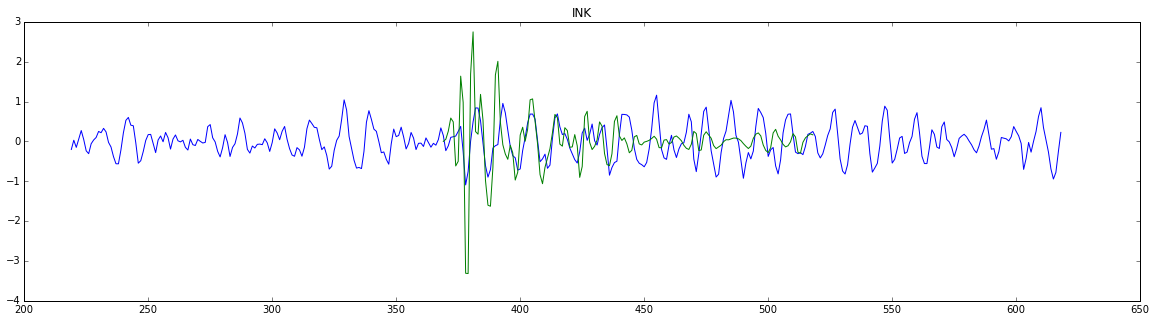

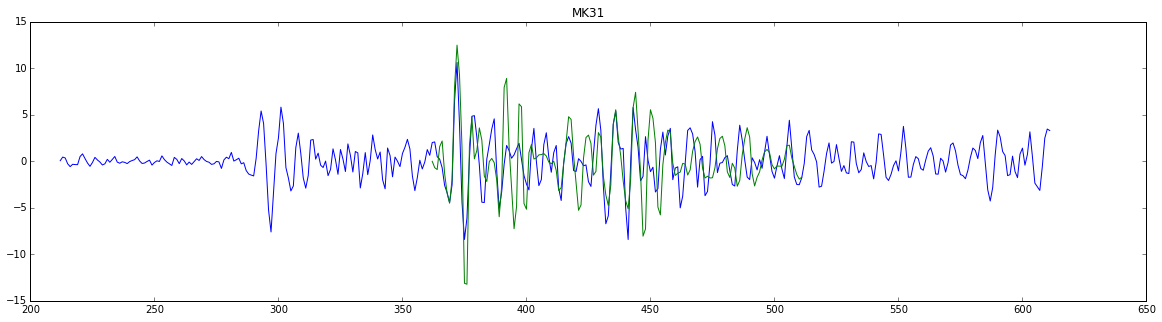

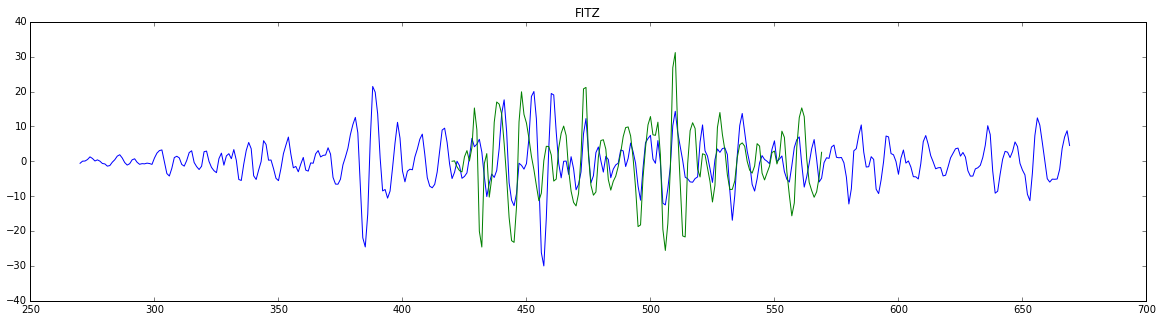

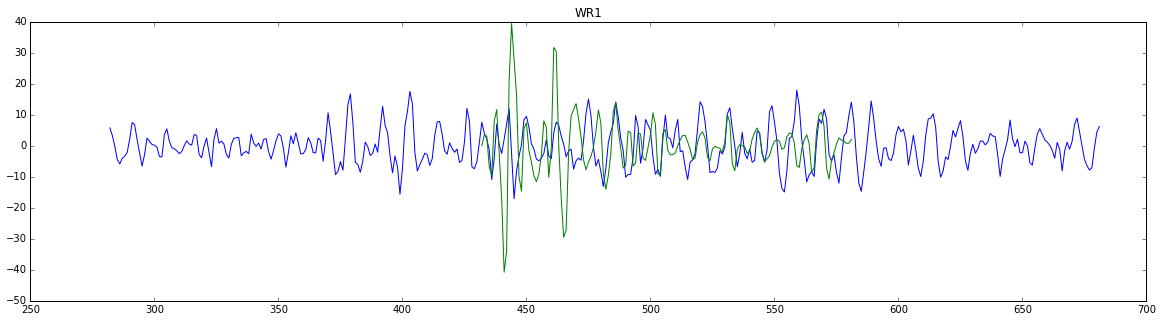

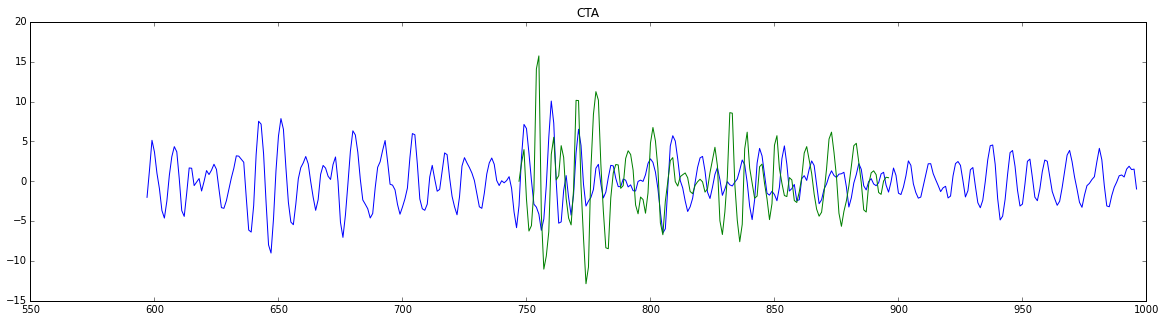

In [24]:
#def correlation_peak_time_dist(sg, wn, tmvals, eid, phase, prebirth_unexplained):

for sta, wns in sg.station_waves.items():
    for wn in wns:
        assert( wn.wavelet_basis is not None)

        phase = "P"
        try:
            tmvals = sg.get_template_vals(new_eid, wn.sta, "P", "freq_0.8_4.5", "BHZ")
        except:
            continue
        wn = sg.station_waves[wn.sta][0]
        
        (start_idxs, end_idxs, identities, basis_prototypes, n_steps) = wn.wavelet_basis
        tg = sg.template_generator("P")

        wn._set_cssm_priors_from_model(arrivals=[(new_eid, phase)])
        cssm = wn.arrival_ssms[(new_eid, phase)]
        n_steps = 150
        pred_wavelet = cssm.mean_obs(n_steps)
        env = np.exp(tg.abstract_logenv_raw(tmvals, srate=wn.srate, fixedlen=n_steps))

        pred_signal = pred_wavelet * env

        ll = ar_advantage(prebirth_unexplained[wn.label], pred_signal, wn.nm)
        maxll = np.argmax(ll)
        
        idx_start = maxll - 150
        idx_end = maxll + 250
        
        figure(figsize=(20, 5))
        xs = np.arange(idx_start, idx_end)
        plot(xs, prebirth_unexplained[wn.label][idx_start:idx_end])
        xs = np.arange(maxll, maxll+len(pred_signal))
        
        v1 = np.linalg.norm(prebirth_unexplained[wn.label][idx_start:idx_end])
        v2 = np.linalg.norm(pred_signal)
        plot(xs, (v1/v2)*pred_signal)
        title("%s" % sta)



    

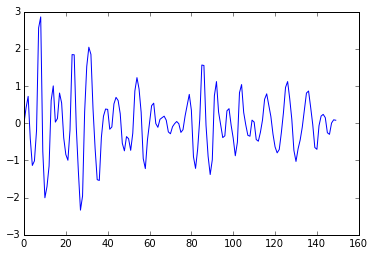

In [25]:
plot(pred_signal)

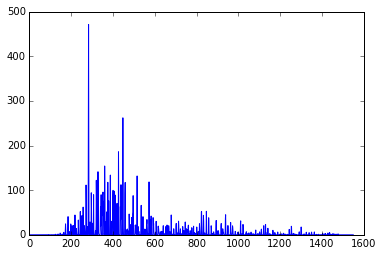

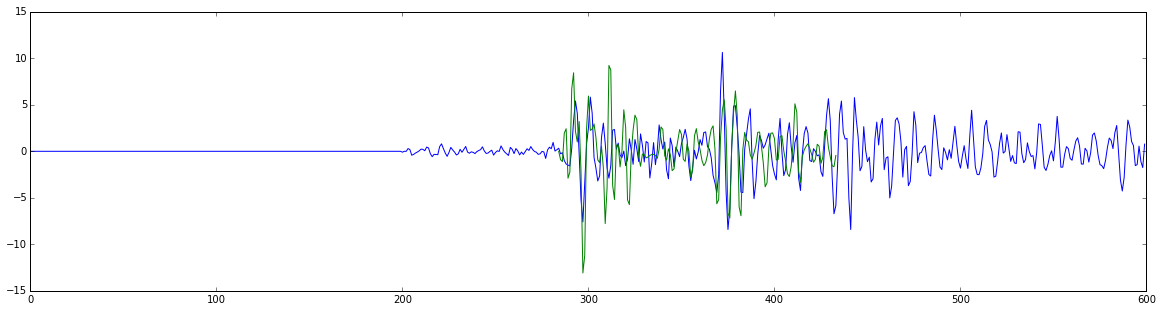

In [39]:
plot(ll)
np.argmax(ll)



0.453191834581
262
0.695496941624
292


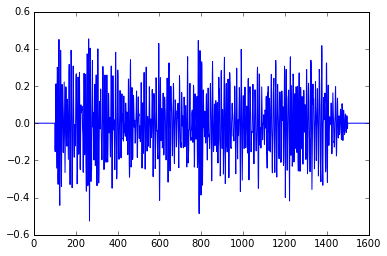

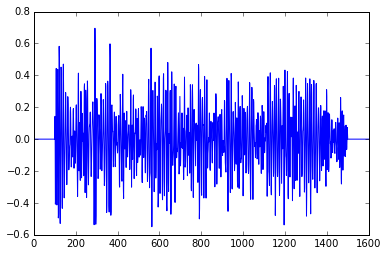

In [18]:
sta = "FITZ"
chan = "BHZ"
c1 = history[5][1][(sta, chan, "freq_0.8_4.5")]
c2 = history[best_weight_idx][1][(sta, chan, "freq_0.8_4.5")]

from sigvisa.signals.xc import my_xc
wn = sg.station_waves[sta][0]
sdata = wn.get_value()
sdata[np.isnan(sdata)] = 0

xc1 = my_xc(c1, sdata)
xc2 = my_xc(c2, sdata)

xc1[np.isnan(xc1)] = 0
xc2[np.isnan(xc2)] = 0

plot(xc1)
print np.max(xc1)
cm1 = np.argmax(xc1)
print cm1
figure()
plot(xc2)
print np.max(xc2)
cm2 = np.argmax(xc2)
print cm2

973.730961204
391
3281.58210004
364


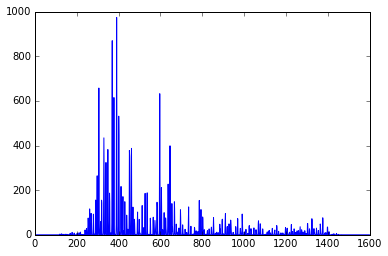

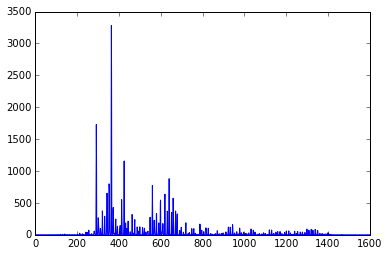

In [19]:
l1 = iid_advantage(sdata, c1)
l2 = iid_advantage(sdata, c2)
plot(l1)
print np.max(l1)
am1 = np.argmax(l1)
print np.argmax(l1)
figure()
plot(l2)
print np.max(l2)
am2 = np.argmax(l2)
print np.argmax(l2)


35.1990596828
391
118.743231284
364


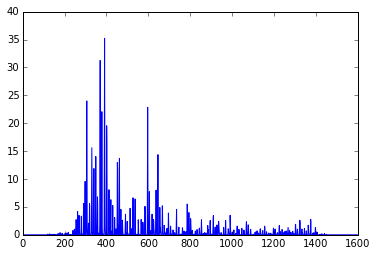

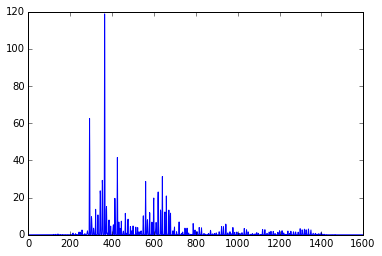

In [20]:
nm = estimate_ar(sdata, n_p=0)
l1 = ar_advantage(sdata, c1, nm)
l2 = ar_advantage(sdata, c2, nm)
plot(l1)
print np.max(l1)
am1 = np.argmax(l1)
print np.argmax(l1)
figure()
plot(l2)
print np.max(l2)
am2 = np.argmax(l2)
print np.argmax(l2)

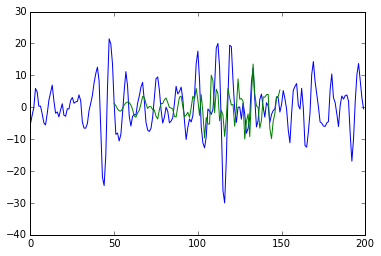

In [21]:
idx1 = am1-50
idx2 = am1 + 150

plot(sdata[idx1:idx2])
xs = np.arange(50, 150)
plot(xs, 41*c1)

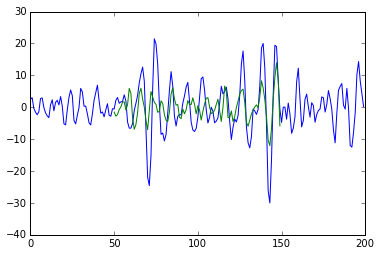

In [22]:
idx1 = am2-50
idx2 = am2 + 150

plot(sdata[idx1:idx2])
xs = np.arange(50, 150)
plot(xs, 41*c2)

In [26]:
wn.nm.log_p(sdata)

-265865.85954253015